In [145]:
import os
import sys
import pandas as pd

package_path = os.path.join(os.getcwd(),'..')
sys.path.insert(0, package_path)

from future_vehicle_demand_model.stock_model.vehicle_stock_model import vehicle_stock_model
from future_vehicle_demand_model.vehicle_ownership.vehicle_ownership import (get_vehicle_ownership_bootstrap_predictions,
                                                                             get_vehicle_ownership_bootstrap_predictions_backward)

import numpy as np
import matplotlib.pyplot as plt


In [146]:
base_year = 2020
base_vehicle_ownership = 55
data = pd.read_excel("../future_vehicle_demand_model/forecast_data/Nigeria.xlsx",index_col=0)
data_forward = data.loc[base_year:]
data_backward = data.loc[base_year::-1]
data.columns

Index(['Population', 'Car_lifetime', 'BEV_share', 'Population_density',
       'Urban_population_percentage', 'Urban_population_density', 'GDP_pc',
       'GDP'],
      dtype='object')

In [147]:
data_forward["Population_density"].values

array([234.    , 240.3375, 246.675 , 253.0125, 259.35  , 265.6875,
       272.025 , 278.3625, 284.7   , 291.0375, 297.375 , 303.7125,
       310.05  , 316.3875, 322.725 , 329.0625, 335.4   , 341.7375,
       348.075 , 354.4125, 360.75  , 367.0875, 373.425 , 379.7625,
       386.1   , 392.4375, 398.775 , 405.1125, 411.45  , 417.7875,
       424.125 ])

In [148]:
# get bootstrap predictions for vehicle ownership: foreward
veh_own_foreward = get_vehicle_ownership_bootstrap_predictions(55,"NGA",data_forward["Population_density"].values,
                                                               data_forward["Urban_population_percentage"].values,data_forward["Urban_population_density"].values,
                                                               data_forward["GDP_pc"].values)
veh_own_backward = get_vehicle_ownership_bootstrap_predictions_backward(55,"NGA",data_backward["Population_density"].values,
                                                               data_backward["Urban_population_percentage"].values,data_backward["Urban_population_density"].values,
                                                               data_backward["GDP_pc"].values)
veh_own = np.concatenate((veh_own_backward[:0:-1],veh_own_foreward))

In [149]:
results = []
for vo in veh_own.transpose():
    results.append(vehicle_stock_model(data.index,data["Population"],vo,data["Car_lifetime"],data["BEV_share"]))


plot prediction intervals for stocks and inflows

In [150]:
inflows_by_years_BEV = np.zeros((len(data.index),len(veh_own.transpose())))
inflows_by_years_ICE = np.zeros((len(data.index),len(veh_own.transpose())))
inflows_by_years_total = np.zeros((len(data.index),len(veh_own.transpose())))

stocks_by_years_BEV = np.zeros((len(data.index),len(veh_own.transpose())))
stocks_by_years_ICE = np.zeros((len(data.index),len(veh_own.transpose())))
stocks_by_years_total = np.zeros((len(data.index),len(veh_own.transpose())))

for j,r in enumerate (results):
    for i in range(len(data.index)):
        inflows_by_years_BEV[i,j] = r["BEV"]["inflow"][i]
        inflows_by_years_ICE[i,j] = r["ICE"]["inflow"][i]
        inflows_by_years_total[i,j] = r["total"]["inflow"][i]
        stocks_by_years_BEV[i,j] = r["BEV"]["stock"][i]
        stocks_by_years_ICE[i,j] = r["ICE"]["stock"][i]
        stocks_by_years_total[i,j] = r["total"]["stock"][i]

In [151]:
upper_BEV = {"inflow":np.zeros(len(inflows_by_years_BEV)),"stock":np.zeros(len(inflows_by_years_BEV))}
lower_BEV = {"inflow":np.zeros(len(inflows_by_years_BEV)),"stock":np.zeros(len(inflows_by_years_BEV))}
iq_upper_BEV = {"inflow":np.zeros(len(inflows_by_years_BEV)),"stock":np.zeros(len(inflows_by_years_BEV))}
iq_lower_BEV = {"inflow":np.zeros(len(inflows_by_years_BEV)),"stock":np.zeros(len(inflows_by_years_BEV))}
predict_BEV ={"inflow":np.zeros(len(inflows_by_years_BEV)),"stock":np.zeros(len(inflows_by_years_BEV))}
upper_ICE = {"inflow":np.zeros(len(inflows_by_years_BEV)),"stock":np.zeros(len(inflows_by_years_BEV))}
lower_ICE ={"inflow":np.zeros(len(inflows_by_years_BEV)),"stock":np.zeros(len(inflows_by_years_BEV))}
iq_upper_ICE = {"inflow":np.zeros(len(inflows_by_years_BEV)),"stock":np.zeros(len(inflows_by_years_BEV))}
iq_lower_ICE = {"inflow":np.zeros(len(inflows_by_years_BEV)),"stock":np.zeros(len(inflows_by_years_BEV))}
predict_ICE = {"inflow":np.zeros(len(inflows_by_years_BEV)),"stock":np.zeros(len(inflows_by_years_BEV))}
upper_total = {"inflow":np.zeros(len(inflows_by_years_BEV)),"stock":np.zeros(len(inflows_by_years_BEV))}
lower_total = {"inflow":np.zeros(len(inflows_by_years_BEV)),"stock":np.zeros(len(inflows_by_years_BEV))}
iq_upper_total = {"inflow":np.zeros(len(inflows_by_years_BEV)),"stock":np.zeros(len(inflows_by_years_BEV))}
iq_lower_total = {"inflow":np.zeros(len(inflows_by_years_BEV)),"stock":np.zeros(len(inflows_by_years_BEV))}
predict_total = {"inflow":np.zeros(len(inflows_by_years_BEV)),"stock":np.zeros(len(inflows_by_years_BEV))}
alpha = 0.05
likely_percentile = 50

for name in ["inflow","stock"]:
    for i in range(len(inflows_by_years_BEV)):
        if name == "inflow":
            C_BEV = inflows_by_years_BEV[i,:]
            C_ICE = inflows_by_years_ICE[i,:]
            C_total = inflows_by_years_total[i,:]
        elif name == "stock":
            C_BEV = stocks_by_years_BEV[i,:]
            C_ICE = stocks_by_years_ICE[i,:]
            C_total = stocks_by_years_total[i,:]

        qs = [100 * alpha / 2, 100 * (1 - alpha / 2),likely_percentile,25,75]
        percentiles = np.percentile(C_BEV, q = qs)
        upper_BEV[name][i] = percentiles[1]
        lower_BEV[name][i] = percentiles[0]
        predict_BEV[name][i] = percentiles[2]
        iq_upper_BEV[name][i] = percentiles[4]
        iq_lower_BEV[name][i] = percentiles[3]

        percentiles = np.percentile(C_ICE, q = qs)
        upper_ICE[name][i] = percentiles[1]
        lower_ICE[name][i] = percentiles[0]
        predict_ICE[name][i] = percentiles[2]
        iq_upper_ICE[name][i] = percentiles[4]
        iq_lower_ICE[name][i] = percentiles[3]

        percentiles = np.percentile(C_total, q = qs)
        upper_total[name][i] = percentiles[1]
        lower_total[name][i] = percentiles[0]
        predict_total[name][i] = percentiles[2]
        iq_upper_total[name][i] = percentiles[4]
        iq_lower_total[name][i] = percentiles[3]

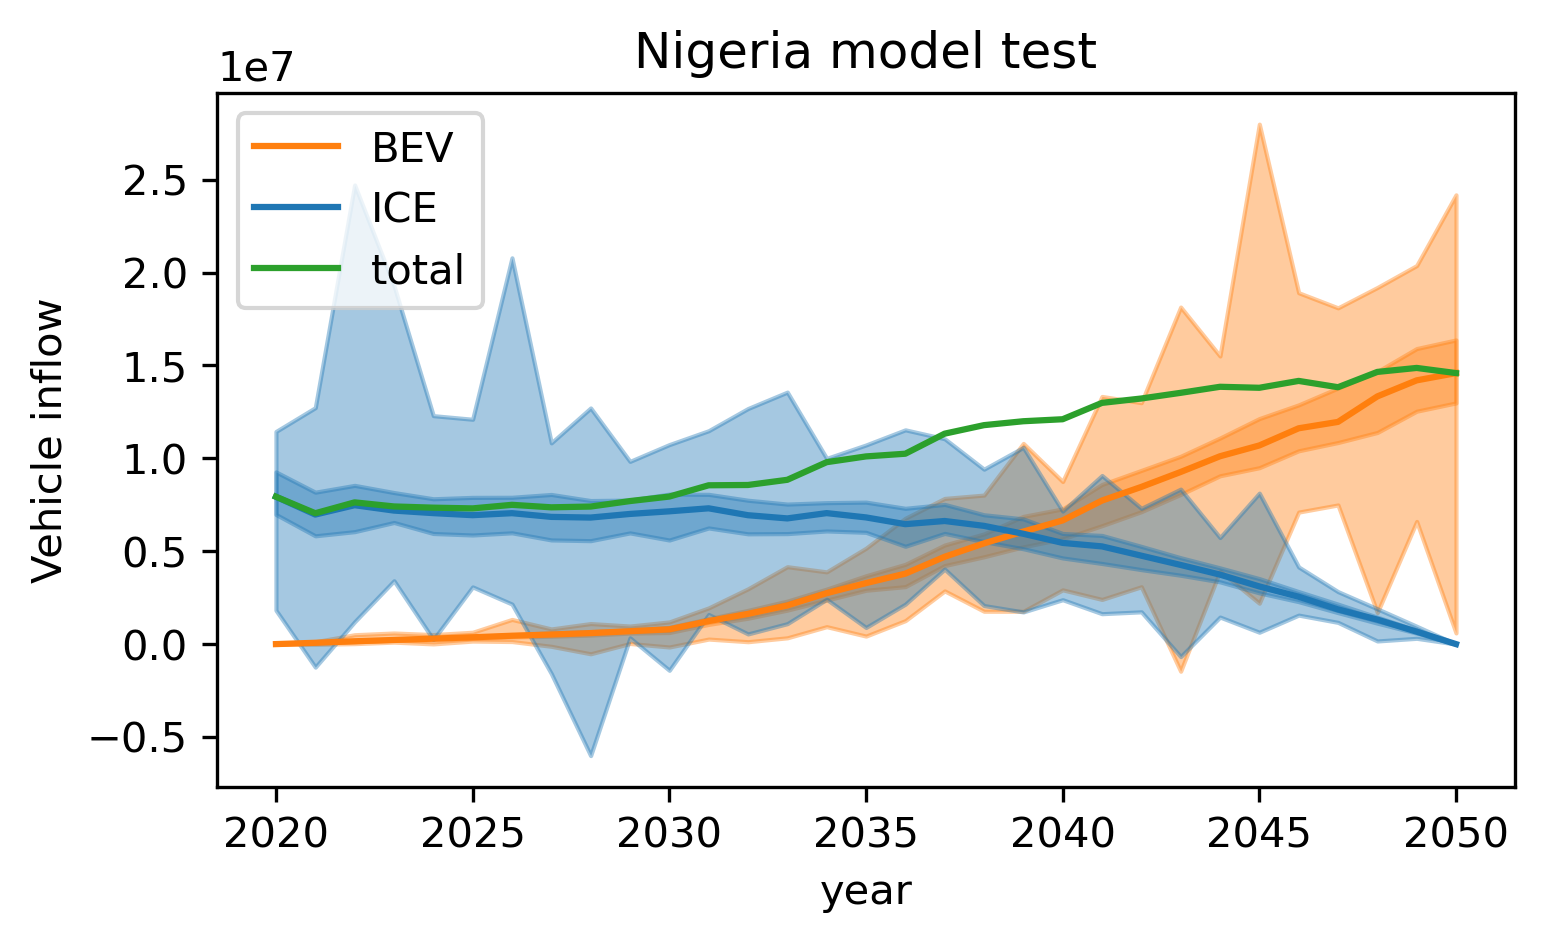

In [152]:
name = "inflow"

fig,ax = plt.subplots(figsize=[3.5*1.5,3.5*1.5/1.618],dpi=300)

ax.plot(data.index[15:],predict_BEV[name][15:],label="BEV",color="tab:orange")
ax.plot(data.index[15:],predict_ICE[name][15:],label="ICE",color="tab:blue")
ax.plot(data.index[15:],predict_total[name][15:],label="total",color="tab:green")

ax.fill_between(data.index[15:], upper_BEV[name][15:], lower_BEV[name][15:],color="tab:orange",alpha = 0.4)
ax.fill_between(data.index[15:], iq_upper_BEV[name][15:], iq_lower_BEV[name][15:],color="tab:orange",alpha = 0.4)
ax.fill_between(data.index[15:], upper_ICE[name][15:], lower_ICE[name][15:],color="tab:blue",alpha = 0.4)
ax.fill_between(data.index[15:], iq_upper_ICE[name][15:], iq_lower_ICE[name][15:],color="tab:blue",alpha = 0.4)
# ax.fill_between(data.index[15:], upper_total[name][15:], lower_total[name][15:],color="tab:blue",alpha = 0.4)
# ax.fill_between(data.index[15:], iq_upper_total[name][15:], iq_lower_total[name][15:],color="tab:blue",alpha = 0.4)

#ax.fill_between(data.index[15:], iq_upper, iq_lower,color="tab:blue",alpha = 0.4,label="interquartile range")

#ax.set_ylim([0,1000])
ax.set_xlabel("year")
ax.set_ylabel("Vehicle inflow")
ax.set_title("Nigeria model test")
ax.legend(loc="upper left")
fig.tight_layout()

fig.savefig("Nigeria_stock_model_inflow.jpg")

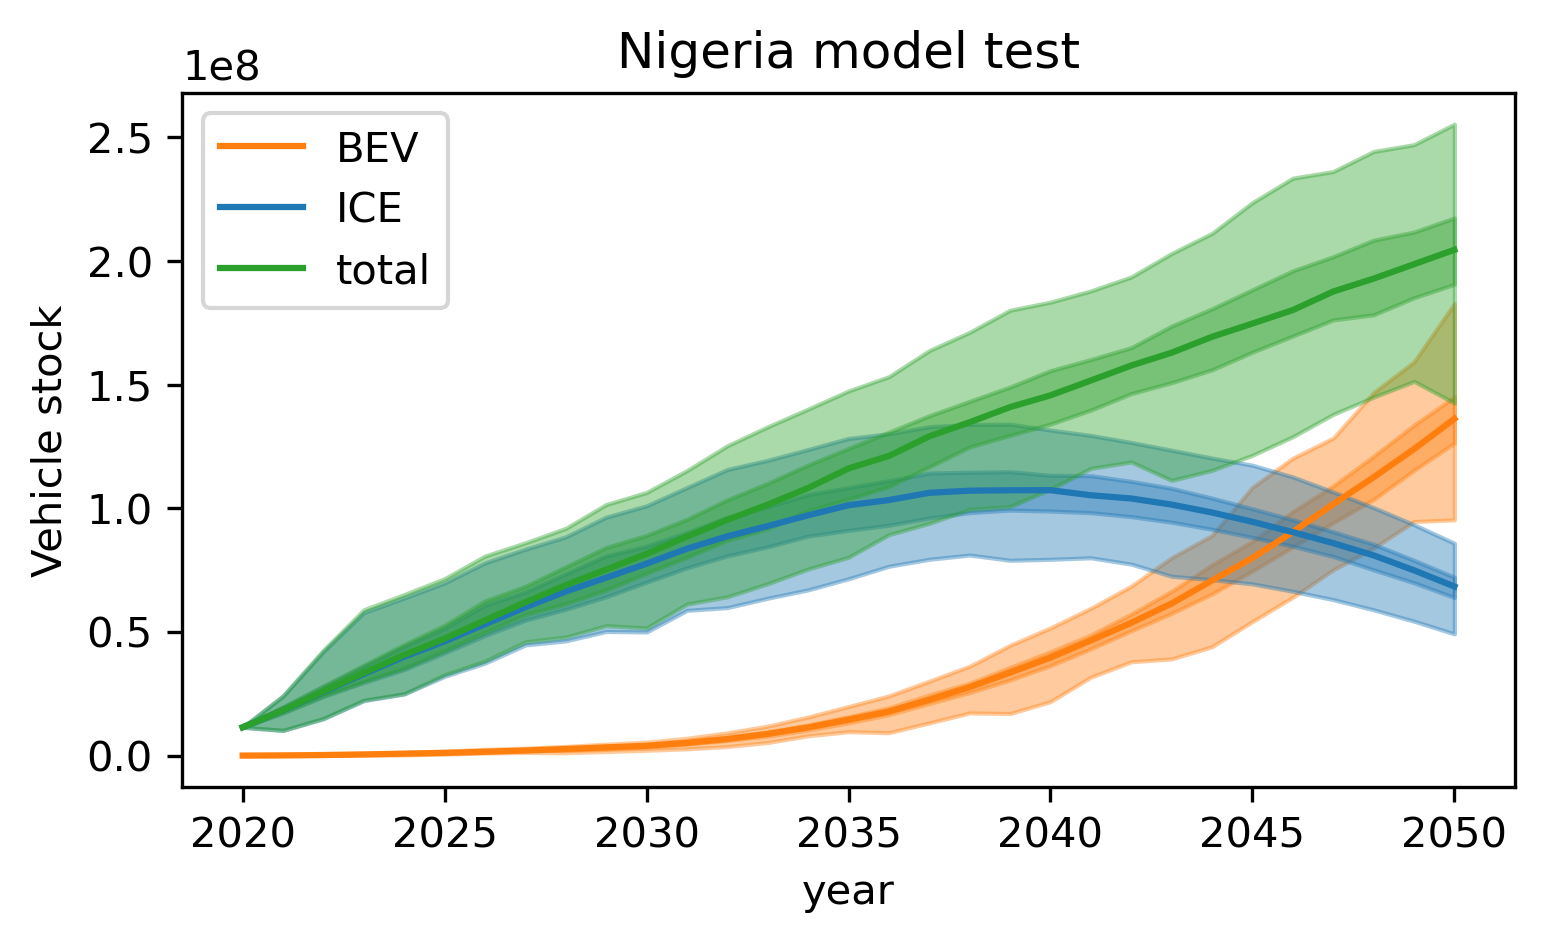

In [153]:
name = "stock"

fig,ax = plt.subplots(figsize=[3.5*1.5,3.5*1.5/1.618],dpi=300)

ax.plot(data.index[15:],predict_BEV[name][15:],label="BEV",color="tab:orange")
ax.plot(data.index[15:],predict_ICE[name][15:],label="ICE",color="tab:blue")
ax.plot(data.index[15:],predict_total[name][15:],label="total",color="tab:green")

ax.fill_between(data.index[15:], upper_BEV[name][15:], lower_BEV[name][15:],color="tab:orange",alpha = 0.4)
ax.fill_between(data.index[15:], iq_upper_BEV[name][15:], iq_lower_BEV[name][15:],color="tab:orange",alpha = 0.4)
ax.fill_between(data.index[15:], upper_ICE[name][15:], lower_ICE[name][15:],color="tab:blue",alpha = 0.4)
ax.fill_between(data.index[15:], iq_upper_ICE[name][15:], iq_lower_ICE[name][15:],color="tab:blue",alpha = 0.4)
ax.fill_between(data.index[15:], upper_total[name][15:], lower_total[name][15:],color="tab:green",alpha = 0.4)
ax.fill_between(data.index[15:], iq_upper_total[name][15:], iq_lower_total[name][15:],color="tab:green",alpha = 0.4)

#ax.fill_between(data.index[15:], iq_upper, iq_lower,color="tab:blue",alpha = 0.4,label="interquartile range")

#ax.set_ylim([0,1000])
ax.set_xlabel("year")
ax.set_ylabel("Vehicle stock")
ax.set_title("Nigeria model test")
ax.legend(loc="upper left")
fig.tight_layout()

fig.savefig("Nigeria_stock_model_stock.jpg")